In [ ]:
! pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 14.8 MB 55.4 MB/s 
     |████████████████████████████████| 132 kB 68.8 MB/s 
     |████████████████████████████████| 462 kB 73.6 MB/s 
     |████████████████████████████████| 2.9 MB 55.4 MB/s 
     |████████████████████████████████| 3.8 MB 56.5 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68716 sha256=9fe82f96f06bbe5e651114c593305924bae64890f038295b5db04b6c46fb5a4a
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  A

In [ ]:
# Import tensorflow and print current version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Import rest of libraries used in the code. Usually this is done at the beginning of the document but it can be done at any position
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta
from tensorflow.keras.callbacks import LearningRateScheduler
import os
import random

In [ ]:
theSEED = 232323
tf.random.set_seed(theSEED)
np.random.seed(theSEED)
random.seed(theSEED)

In [ ]:
# Hyperparameters:
# They must be carefully select depending on the dataset and model

NB_EPOCH = 5       # Number of training epochs
VALIDATION_SPLIT=0.2 # Size of the validation split taken from the training set. If your dataset has validation split, skip this part.

Cargamos el dataset:

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!mkdir -p '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [ ]:
!gdown --id '14CuNJzfpF-HCOcgYXE1XF0umKIxCScB7' -O '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip'

In [ ]:
!unzip '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip' -d '/content/gdrive/MyDrive/Curso-Jetson/imagenes/'

unzip:  cannot find or open /content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip, /content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip.zip or /content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip.ZIP.


In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits'

Test  Training


In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training'

Banana	Lemon  Orange  Strawberry


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training', labels='inferred', subset="training", validation_split=VALIDATION_SPLIT, seed=0)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training', labels='inferred', subset="validation", validation_split=VALIDATION_SPLIT, seed=0)

Found 1953 files belonging to 4 classes.
Using 1563 files for training.
Found 1953 files belonging to 4 classes.
Using 390 files for validation.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Vamos a visualizar una de las muestras y la clase a la que pertenece:

In [ ]:
def process(image,label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [ ]:
#resize_and_rescale = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
#  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#])

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Create a pretrained model.
base_model = tf.keras.applications.MobileNetV2(
  input_tensor=None, include_top=False, 
  weights='imagenet', input_shape=(224,224,3), classes=4)
base_model.trainable = True
model = tf.keras.Sequential()
#model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.build((None, 224,224,3))
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               384300    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________

In [ ]:
model.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=NB_EPOCH, validation_data=val_ds)

Epoch 1/5
49/49 [==============================] - 376s 6s/step - loss: 1.4898 - accuracy: 0.3496 - val_loss: 1.1744 - val_accuracy: 0.5359
Epoch 2/5
49/49 [==============================] - 15s 295ms/step - loss: 0.8491 - accuracy: 0.7569 - val_loss: 0.9521 - val_accuracy: 0.7051
Epoch 3/5
49/49 [==============================] - 15s 297ms/step - loss: 0.5127 - accuracy: 0.9213 - val_loss: 0.8094 - val_accuracy: 0.7590
Epoch 4/5
49/49 [==============================] - 15s 301ms/step - loss: 0.3207 - accuracy: 0.9771 - val_loss: 0.7289 - val_accuracy: 0.7590
Epoch 5/5
49/49 [==============================] - 15s 300ms/step - loss: 0.2012 - accuracy: 0.9939 - val_loss: 0.6688 - val_accuracy: 0.7615


In [ ]:
model.evaluate(val_ds)

13/13 [==============================] - 2s 76ms/step - loss: 0.6688 - accuracy: 0.7615


[0.6688096523284912, 0.7615384459495544]

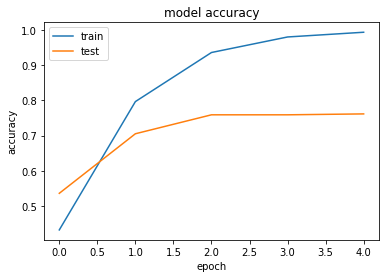

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

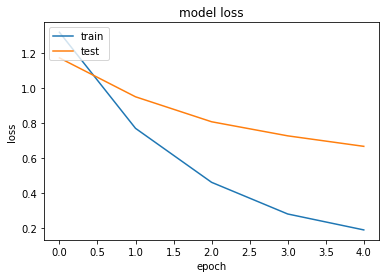

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.layers.pop(0)
#model.layers.pop(0)
newInput = tf.keras.layers.Input(batch_shape=(None,224,224,3))
newOutputs = model(newInput)
newModel = tf.keras.Model(newInput, newOutputs)
newModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 4)                 2672788   
Total params: 2,672,788
Trainable params: 2,638,676
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
newModel.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
newModel.evaluate(val_ds)

13/13 [==============================] - 6s 115ms/step - loss: 0.7002 - accuracy: 0.7487


[0.668809711933136, 0.7615384459495544]

In [ ]:
# Save model
OUT_MODEL_PATH= '/content/gdrive/MyDrive/Curso-Jetson/models'
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-pract2.hdf5'))
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-pract2'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Curso-Jetson/models/model-final-pract2/assets


In [ ]:
!ls $OUT_MODEL_PATH

model-final-pract1	 model-final-pract2
model-final-pract1.hdf5  model-final-pract2.hdf5
